# pytorch master [doc](https://pytorch.org/docs/stable/nn.html)

In [24]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## get some batch 

In [2]:
from process import get_data
from torchtext import data

In [3]:
data_path = "dataset/"
file_name = "train."

In [4]:
txt_en, train_en = get_data(file_path = data_path + file_name + 'en',
                           field_name = 'en')

In [5]:
train_loader = data.Iterator(train_en, batch_size = 3,
                            device = None, # if using GPU, type "cuda" 
                            repeat = False)

In [6]:
for batch in train_loader:
    break

In [7]:
a = batch.en

In [8]:
del txt_en, train_en, train_loader, batch.en

In [9]:
a.shape

torch.Size([3, 18])

In [10]:
b = a[1]

## Embeddings
- super().__init__() : nn.Module의 __init__() 상속
[ref](https://rednooby.tistory.com/56)
- nn.Embedding(V, D) : V = #(Vocab), D = #(Dim)
V, D 만큼의 Embedding 생성

In [11]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model, padding_idx = 1)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [12]:
emb = nn.Embedding(25000, 128, padding_idx = 1)

In [13]:
emb = Embeddings(d_model = 128, vocab = 25000)

In [14]:
x = emb(b).unsqueeze(0)

In [15]:
x

tensor([[[  0.6198,   8.6492,   3.6310,  ...,  -9.9202,  17.4055,   2.7748],
         [ 15.1089,  22.9400, -11.8182,  ...,   7.4611,  18.0855, -15.2930],
         [ -1.4648,  -8.7129,   6.4658,  ...,  -9.4260,   8.7015,   4.2287],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]],
       grad_fn=<UnsqueezeBackward0>)

In [16]:
x.shape

torch.Size([1, 18, 128])

In [17]:
x.size(1)

18

## Positional Encoding

"::" : seq[start:end:step] 

torch.nn.register_buffer : Adds a persistent buffer to the module.

torch.autograd.Variable : 이후 Gradient 흘려줄 변수로 지정

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        pe = torch.zeros(max_len, d_model, dtype = torch.float)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype = torch.float) / 
                             d_model * -math.log(1e+4))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad = False)
        return self.dropout(x)

In [19]:
d_model = 128
max_len = 5000

In [20]:
PE = PositionalEncoding(d_model = 128, dropout = .1)

In [21]:
x.shape

torch.Size([1, 18, 128])

In [22]:
PE.forward(x)

tensor([[[ 6.8864e-01,  0.0000e+00,  4.0344e+00,  ..., -9.9113e+00,
           1.9339e+01,  4.1942e+00],
         [ 0.0000e+00,  2.6089e+01, -1.2285e+01,  ...,  9.4013e+00,
           2.0095e+01, -0.0000e+00],
         [-6.1724e-01, -1.0143e+01,  8.2809e+00,  ..., -9.3622e+00,
           9.6686e+00,  0.0000e+00],
         ...,
         [ 7.2254e-01, -8.4410e-01,  4.5621e-01,  ...,  1.1111e+00,
           1.9246e-03,  1.1111e+00],
         [-3.1989e-01, -1.0641e+00,  1.0673e+00,  ...,  1.1111e+00,
           2.0529e-03,  1.1111e+00],
         [-1.0682e+00, -3.0574e-01,  9.2682e-01,  ...,  1.1111e+00,
           2.1813e-03,  1.1111e+00]]], grad_fn=<MulBackward0>)

1. 판깔기

In [132]:
pe = torch.zeros(max_len, d_model, dtype = torch.float)

2. 각 텀 만들기

In [133]:
position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)

In [134]:
position

tensor([[0.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        ...,
        [4.9970e+03],
        [4.9980e+03],
        [4.9990e+03]])

In [135]:
div_term = torch.exp(torch.arange(0, d_model, 2, dtype = torch.float) / d_model * -math.log(1e+4))

In [136]:
# pow 연산 위치에 따른 비교
div_term - torch.pow(10000, -torch.arange(0, d_model, 2, dtype = torch.float) / d_model)

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.9802e-08, -2.9802e-08,  2.9802e-08,  0.0000e+00, -2.9802e-08,
        -2.9802e-08,  0.0000e+00,  0.0000e+00, -1.4901e-08,  0.0000e+00,
         0.0000e+00, -7.4506e-09,  0.0000e+00, -7.4506e-09, -7.4506e-09,
        -7.4506e-09,  3.7253e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.8626e-09, -3.7253e-09, -3.7253e-09,  0.0000e+00, -2.7940e-09,
         0.0000e+00, -2.7940e-09,  0.0000e+00,  9.3132e-10, -1.3970e-09,
         4.6566e-10, -9.3132e-10,  0.0000e+00, -9.3132e-10, -2.3283e-10,
        -9.3132e-10, -4.6566e-10,  0.0000e+00, -4.6566e-10,  0.0000e+00,
        -3.4925e-10, -1.1642e-10, -3.4925e-10, -1.1642e-10,  1.1642e-10,
        -1.1642e-10,  5.8208e-11, -1.1642e-10, -2.9104e-11, -1.4552e-10,
         0.0000e+00,  5.8208e-11,  8.7311e-11, -1.0186e-10, -4.3656e-11,
         0.0000e+00,  2.9104e-11, -7.2760e-11, -4.3656e-11])

3 합치기

In [137]:
print(div_term.shape, position.shape, pe.shape)

torch.Size([64]) torch.Size([5000, 1]) torch.Size([5000, 128])


In [138]:
(position * div_term).shape

torch.Size([5000, 64])

In [139]:
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

In [140]:
pe = pe.unsqueeze(0)

In [22]:
torch.arange(0, 5000).unsqueeze(1)

tensor([[   0],
        [   1],
        [   2],
        ...,
        [4997],
        [4998],
        [4999]])

In [141]:
pe.shape

torch.Size([1, 5000, 128])

def forward 분석

In [143]:
pe[:, ].shape

torch.Size([1, 5000, 128])

In [146]:
pe[:, :x.size(1)].shape

torch.Size([1, 26, 128])

In [148]:
Variable(pe[:, :x.size(1)]).shape

torch.Size([1, 26, 128])

Visualization for an output

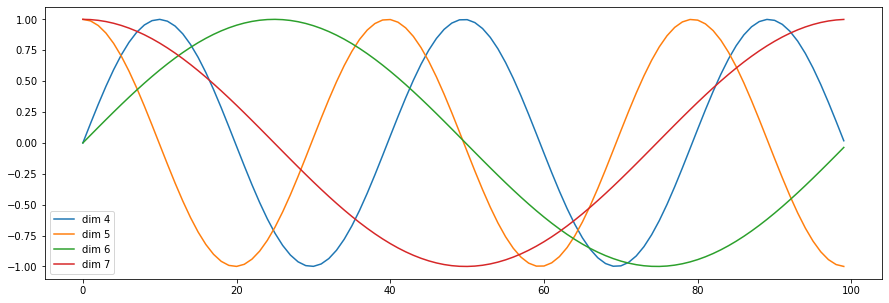

In [27]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None